# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024



##### This block imports necessary packages for API calling, parsing, analysis, and visualization of the API page view data. All packages can be installed by conda activate 'package name' command in anaconda or pip install 'package name' in python/notebook

#### To-Do: Link addition, file name change & upload, create new virtual envir, requirement txt.

In [2]:
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd
import matplotlib.pyplot as plt

##### Read the csv file that contains the subset of article we want to call from API. The format of this file is csv and we mainly use 'disease' column later.

In [3]:
article_subset = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')

The example relies on some constants that help make the code a bit more readable.
We mainly call the pageviews API using the article name, while controlling wih constraints (not exceeding 100 requests per second). In this code, we use parameteres of project,access (3 types), agent, article (title of disease), granularity (time measurement), time frame (start and end date)

In [4]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<ymkim814@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = article_subset['disease']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}


The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [5]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title
    
    if access_type:
        request_template['access'] = access_type
        

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


This for loop takes article name and access as parameters and call the API for pageviews. For example, we can get 'desktop' access or 'mobile-app' and add 'mobile-web' view in the code. The result is a dictionary for each article (disease) like this:\
    "Klinefelter syndrome": [ \
        {\
            "project": "en.wikipedia",\
            "article": "Klinefelter_syndrome",\
            "granularity": "monthly",\
            "timestamp": "2015070100",\
            "agent": "user",\
            "views": 36798\
        }, ...

where each article includes whole timestamp if exists.

The outer for loop runs for each article while the inner article runs for each timestamp adding. At the end, we save the output dictionary as a form of .json file into the same folder we have the notebook file. One can add path lik ,'w', path if needed.


In [6]:
all_desktop_views = {}
for i in ARTICLE_TITLES:
    print("Getting pageview data for:", i, "type", 'desktop')
    desk_views = request_pageviews_per_article(i, 'desktop')    
    desktop_views = []

    if 'items' in desk_views:
        for info in desk_views['items']:
            view_entry = {
                'project': info['project'],
                'article': info['article'],
                'granularity': info['granularity'],
                'timestamp': info['timestamp'],
                'agent': info['agent'],
                'views': info['views']  
            }

            desktop_views.append(view_entry)

    # Store the list of combined views for the current article in all_mobile_views_test
    all_desktop_views[i] = desktop_views

   
with open('desktop_views.json', 'w') as outfile:
    json.dump(all_desktop_views, outfile, indent=4)

Getting pageview data for: Klinefelter syndrome type desktop
Getting pageview data for: Aarskog–Scott syndrome type desktop
Getting pageview data for: Abetalipoproteinemia type desktop
Getting pageview data for: MT-TP type desktop


KeyboardInterrupt: 

The code below has he same logic as above but just add web-mobile to app-mobile to have combined total mobile view.

In [64]:
all_mobile_views = {}
for i in ARTICLE_TITLES:
    print("Getting pageview data for:", i, "type", 'mobile-app')
    app_views = request_pageviews_per_article(i, 'mobile-app')
    print("Getting pageview data for:", i, "type", 'mobile-web')
    web_views = request_pageviews_per_article(i, 'mobile-web')    
 
    # Initialize a list for the current article
    mobile_views = []

    # Check if app_views has 'items'
    if 'items' in web_views:
        for info in web_views['items']:
            view_entry = {
                'project': info['project'],
                'article': info['article'],
                'granularity': info['granularity'],
                'timestamp': info['timestamp'],
                'agent': info['agent'],
                'views': info['views']  
            }
            #print(info['views'])
            if 'items' in app_views:
                for app_info in app_views['items']:
                    if app_info['timestamp'] == info['timestamp']: 
                        view_entry['views'] += app_info['views'] 
                        #print(web_info['views'])
                        break  # No need to continue checking once we find the matching timestamp
            
=            mobile_views.append(view_entry)

    all_mobile_views[i] = mobile_views

    
with open('combined_mobile_views.json', 'w') as outfile:
    json.dump(all_mobile_views, outfile, indent=4)


The code below has he same logic as above but just add web-mobile, app-mobile, and desktop view to have combined total view.

In [95]:

total_views = {}
for i in ARTICLE_TITLES:
    print("Getting pageview data for:", i, "type", 'mobile-app')
    app_views = request_pageviews_per_article(i, 'mobile-app')
    print("Getting pageview data for:", i, "type", 'mobile-web')
    web_views = request_pageviews_per_article(i, 'mobile-web')    
    print("Getting pageview data for:", i, "type", 'desktop')
    desk_views = request_pageviews_per_article(i, 'desktop')    

    total_views_sum = []

    # Check if app_views has 'items'
    if 'items' in desk_views:
        for info in desk_views['items']:
            view_entry = {
                'project': info['project'],
                'article': info['article'],
                'granularity': info['granularity'],
                'timestamp': info['timestamp'],
                'agent': info['agent'],
                'views': info['views'] 
            }

            if 'items' in app_views:
                for app_info in app_views['items']:
                    if app_info['timestamp'] == info['timestamp']:  
                        view_entry['views'] += app_info['views'] 

            if 'items' in web_views:
                for web_info in web_views['items']:
                    if web_info['timestamp'] == info['timestamp']:  
                        view_entry['views'] += web_info['views']  

                        break  # No need to continue checking once we find the matching timestamp
            
            total_views_sum.append(view_entry)

    total_views[i] = total_views_sum
   
with open('total_views.json', 'w') as outfile:
    json.dump(total_views, outfile, indent=4)

Getting pageview data for: Klinefelter syndrome type mobile-app
Getting pageview data for: Klinefelter syndrome type mobile-web
Getting pageview data for: Klinefelter syndrome type desktop
Getting pageview data for: Aarskog–Scott syndrome type mobile-app
Getting pageview data for: Aarskog–Scott syndrome type mobile-web
Getting pageview data for: Aarskog–Scott syndrome type desktop
Getting pageview data for: Abetalipoproteinemia type mobile-app
Getting pageview data for: Abetalipoproteinemia type mobile-web
Getting pageview data for: Abetalipoproteinemia type desktop
Getting pageview data for: MT-TP type mobile-app
Getting pageview data for: MT-TP type mobile-web
Getting pageview data for: MT-TP type desktop
Getting pageview data for: Ablepharon macrostomia syndrome type mobile-app
Getting pageview data for: Ablepharon macrostomia syndrome type mobile-web
Getting pageview data for: Ablepharon macrostomia syndrome type desktop
Getting pageview data for: Acanthocheilonemiasis type mobile-

In [ ]:
# print(json.dumps(views,indent=4))
# print(f"Collected {len(views['items'])} months of pageview data")
# for month in views['items']:
#     print(json.dumps(month,indent=4))

Above output should show dictionaries with views per month

Once we finished exporting desktop file and combined mobile views, we exported them as json file since API calling takes long time - which is inefficient to call them frequntly. Then we normalize json file format to create as pandas dataframe format. The dataframe consists of seven columns - project, article, granularity, timestamp, agent, views, and month. Months is corresponding timestampe, but it was created for easier visualization of monthly time series and legend creation. We will mainly use month, article, and views for analysis.  

In [7]:
# Load the JSON data from both desktop and mobile views
with open('rare-disease_monthly_desktop_201507-202409.json', 'r') as desktop_file:
    desktop_data = json.load(desktop_file)

with open('rare-disease_monthly_mobile_201507-202409.json', 'r') as mobile_file:
    mobile_data = json.load(mobile_file)

# Function to process and normalize the data
def process_data(json_data):
    df_list = []
    for disease, entries in json_data.items():
        temp_df = pd.json_normalize(entries)
        df_list.append(temp_df)
    df = pd.concat(df_list, ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    df['month'] = df['timestamp'].dt.to_period('M')
    return df

# Process desktop and mobile data
desktop_df = process_data(desktop_data)
mobile_df = process_data(mobile_data)


##### Maximum Average and Minimum Average

This code calculates average pageview of each disease by group by each disease and get the average of views. It creates a new dataframe with article name and its average views. Columns are renamed to prevent any naming confusion.

In [84]:
desktop_avg_views = desktop_df.groupby('article')['views'].mean().reset_index()
mobile_avg_views = mobile_df.groupby('article')['views'].mean().reset_index()

# Rename the average columns
desktop_avg_views.columns = ['article', 'avg_views']
mobile_avg_views.columns = ['article', 'avg_views']

This code selects the highest and smallest average view for mobile and desktop views and create the table with views and article names. Then we filtered the original dataset for only those 4 articles to have timestamp and views for plotting.

In [85]:
# Select the articles with the highest and lowest average views
max_desktop = desktop_avg_views.nlargest(1, 'avg_views')
min_desktop = desktop_avg_views.nsmallest(1, 'avg_views')
max_mobile = mobile_avg_views.nlargest(1, 'avg_views')
min_mobile = mobile_avg_views.nsmallest(1, 'avg_views')

# Combine the selected articles into a single DataFrame
selected_articles = pd.concat([max_desktop, min_desktop, max_mobile, min_mobile])

max_desktop_data = desktop_df[desktop_df['article'] == max_desktop['article'].values[0]]
min_desktop_data = desktop_df[desktop_df['article'] == min_desktop['article'].values[0]]
max_mobile_data = mobile_df[mobile_df['article'] == max_mobile['article'].values[0]]
min_mobile_data = mobile_df[mobile_df['article'] == min_mobile['article'].values[0]]

Lastly, we plot the result using matplotlib library in python. We plot 4 lines, while using different linestyle for mobile and desktop to distinguish them. The title reflects what we plot and month with page views. The ticker is rotated for visibility and savefig saves the visualization as .png file in the same folder as this notebook. We can see that for both desktop and mobile access, black death is the highest and filppi_syndrom is the lowest average page requests. The peak timestamp is also similar, which is early 2020. Howver, mobile views has much higher view for the peak.

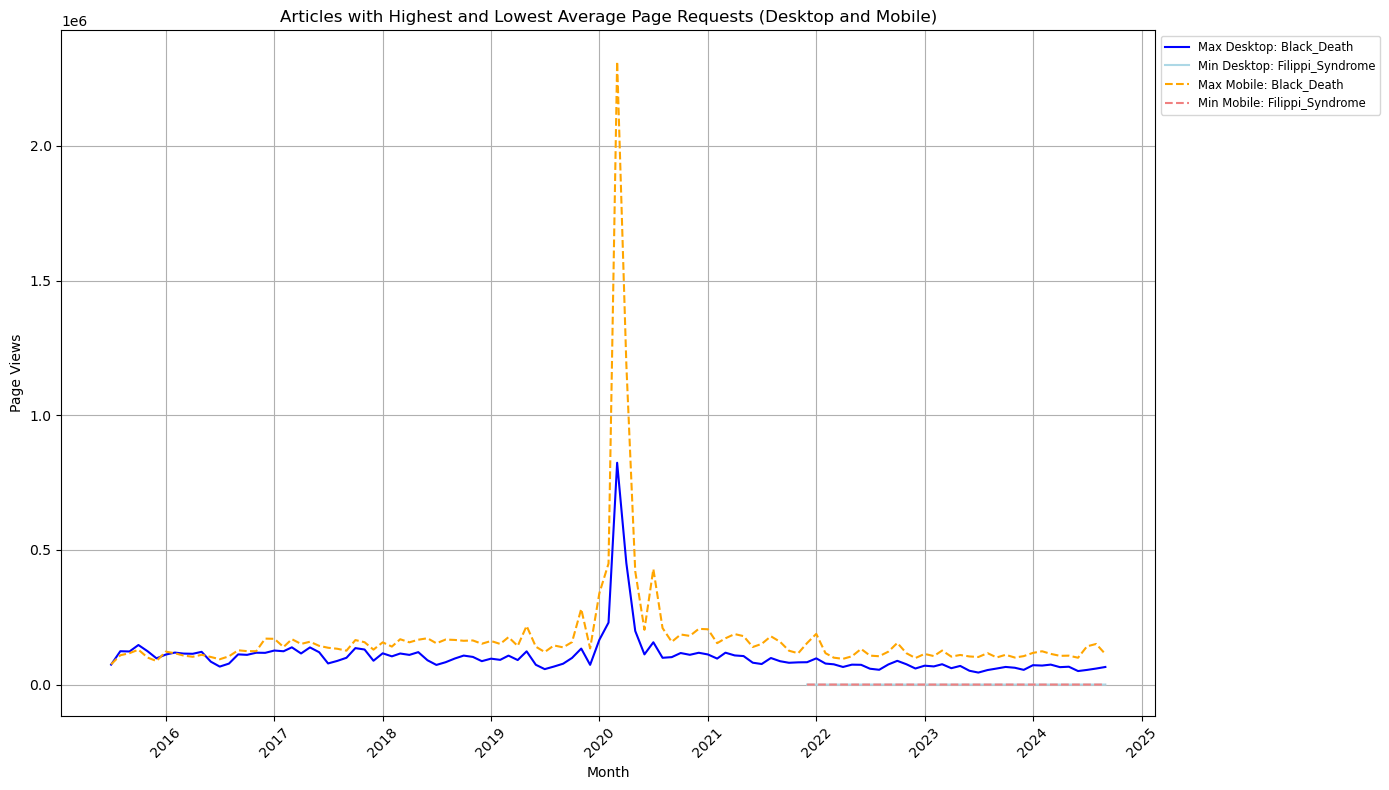

In [47]:
plt.figure(figsize=(14, 8))

# Plotting for Max Desktop Article
plt.plot(max_desktop_data['month'].dt.to_timestamp(), max_desktop_data['views'], 
         label=f'Max Desktop: {max_desktop["article"].values[0]}', linestyle='-', color='blue')

# Plotting for Min Desktop Article
plt.plot(min_desktop_data['month'].dt.to_timestamp(), min_desktop_data['views'], 
         label=f'Min Desktop: {min_desktop["article"].values[0]}', linestyle='-', color='lightblue')

# Plotting for Max Mobile Article
plt.plot(max_mobile_data['month'].dt.to_timestamp(), max_mobile_data['views'], 
         label=f'Max Mobile: {max_mobile["article"].values[0]}', linestyle='--', color='orange')

# Plotting for Min Mobile Article
plt.plot(min_mobile_data['month'].dt.to_timestamp(), min_mobile_data['views'], 
         label=f'Min Mobile: {min_mobile["article"].values[0]}', linestyle='--', color='lightcoral')

# Customize the plot
plt.title('Articles with Highest and Lowest Average Page Requests (Desktop and Mobile)')
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)

# Save the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Maximum Average and Minimum Average.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

##### Top 10 Peak Page Views

In this code block, we get the value for the max views for each article and make them as dataframe - with article, views, and months. We rename views for desktop and mobile since we need to merge them on article for comprehensive visualization visualization and distinguish them. The month is automatically renamed as month_x for desktop and month_y for mobile. Join is outer to include all information.

In [88]:
# Function to find peak views for each article
def find_peak_views(df):
    peak_views = df.loc[df.groupby('article')['views'].idxmax()]  
    return peak_views[['article', 'views', 'month']]

desktop_peak_views = find_peak_views(desktop_df).rename(columns={'views': 'peak_views_desktop'})
mobile_peak_views = find_peak_views(mobile_df).rename(columns={'views': 'peak_views_mobile'})

# Merge the peak views data on article names
combined_peak_views = pd.merge(desktop_peak_views, mobile_peak_views, on='article', how='outer')


Then we selected the top 10 article for desktop views and another top 10 for mobile views. One can adjust the parameter to change it from 10 to 5 or 15 with nlargest function. Then like min and max average, we made them as dataframe to filter original data to have only top 10 views for each access type.

In [50]:
# Sort by peak views and select the top 10 for desktop and mobile
top_desktop = combined_peak_views.nlargest(10, 'peak_views_desktop')
top_mobile = combined_peak_views.nlargest(10, 'peak_views_mobile')

# Combine top articles
top_articles = pd.concat([top_desktop[['article', 'peak_views_desktop']], top_mobile[['article', 'peak_views_mobile']]])

# Filter the original DataFrames for only the top articles
top_desktop_articles = desktop_df[desktop_df['article'].isin(top_articles['article'])]
top_mobile_articles = mobile_df[mobile_df['article'].isin(top_articles['article'])]

We made a plot that has total 20 timeseries, top 10 for desktop and top 10 for mobile. We created access - article legend for clarity while making them different styles. We also rotated and adjustd size of label for visibility. savefig exports this visualization to the same folder with notebook as .png file. We can see that the Pandemic and Black Death has very high peak page views, especially in 2020. Regarding max views, mobile and desktop top 10 do not exactly match. 

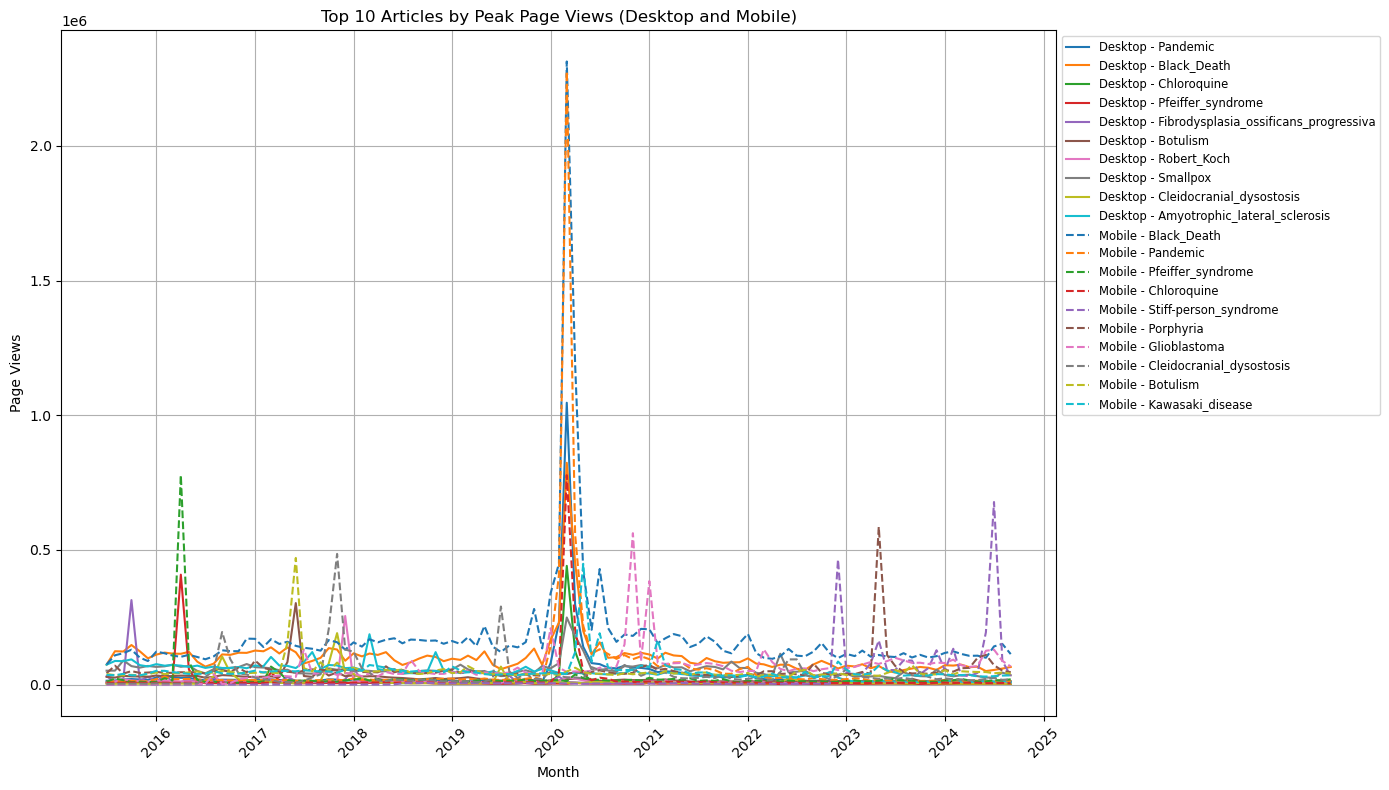

In [57]:
plt.figure(figsize=(14, 8))

for article in top_desktop['article']:
    article_data = top_desktop_articles[top_desktop_articles['article'] == article]
    plt.plot(article_data['month'].dt.to_timestamp(), article_data['views'], label=f'Desktop - {article}')

for article in top_mobile['article']:
    article_data = top_mobile_articles[top_mobile_articles['article'] == article]
    plt.plot(article_data['month'].dt.to_timestamp(), article_data['views'], label=f'Mobile - {article}', linestyle='--')

plt.title('Top 10 Articles by Peak Page Views (Desktop and Mobile)')
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Top 10 Peak Page Views.png')  # Save the plot as a PNG file
plt.show()  

##### Fewest Months of Data
In this code block, we count the number of unique months for each article since we already have month column. Then we rename the column to prevent any confusion. At this time, we use nsmallest with the number of 10 to select articles with shortest months of data. Then we used that dataframe to have timestamp of those 10 fewest month articles for each access type.

In [92]:
# Count the number of unique months for each article for desktop and mobile
desktop_months_count = desktop_df.groupby('article')['month'].nunique().reset_index()
mobile_months_count = mobile_df.groupby('article')['month'].nunique().reset_index()

desktop_months_count.columns = ['article', 'months_available']
mobile_months_count.columns = ['article', 'months_available']

desktop_fewest_months = desktop_months_count.nsmallest(10, 'months_available')
mobile_fewest_months = mobile_months_count.nsmallest(10, 'months_available')

top_desktop_articles = desktop_df[desktop_df['article'].isin(desktop_fewest_months['article'])]
top_mobile_articles = mobile_df[mobile_df['article'].isin(mobile_fewest_months['article'])]

Then we used matplotlib to plot them - although majority of them have very low page views, short period of data does not always indicate small number of page views, especialyl Covid 19 relevant ones. We created access - article legend for clarity while making them different styles. We also rotated and adjustd size of label for visibility. savefig exports this visualization to the same folder with notebook as .png file. In this case, top 10 for mobile and desktop are the same because it is not about the view but timeframe length. Hence, I made the color same for the same article, making it easier to compare the views.

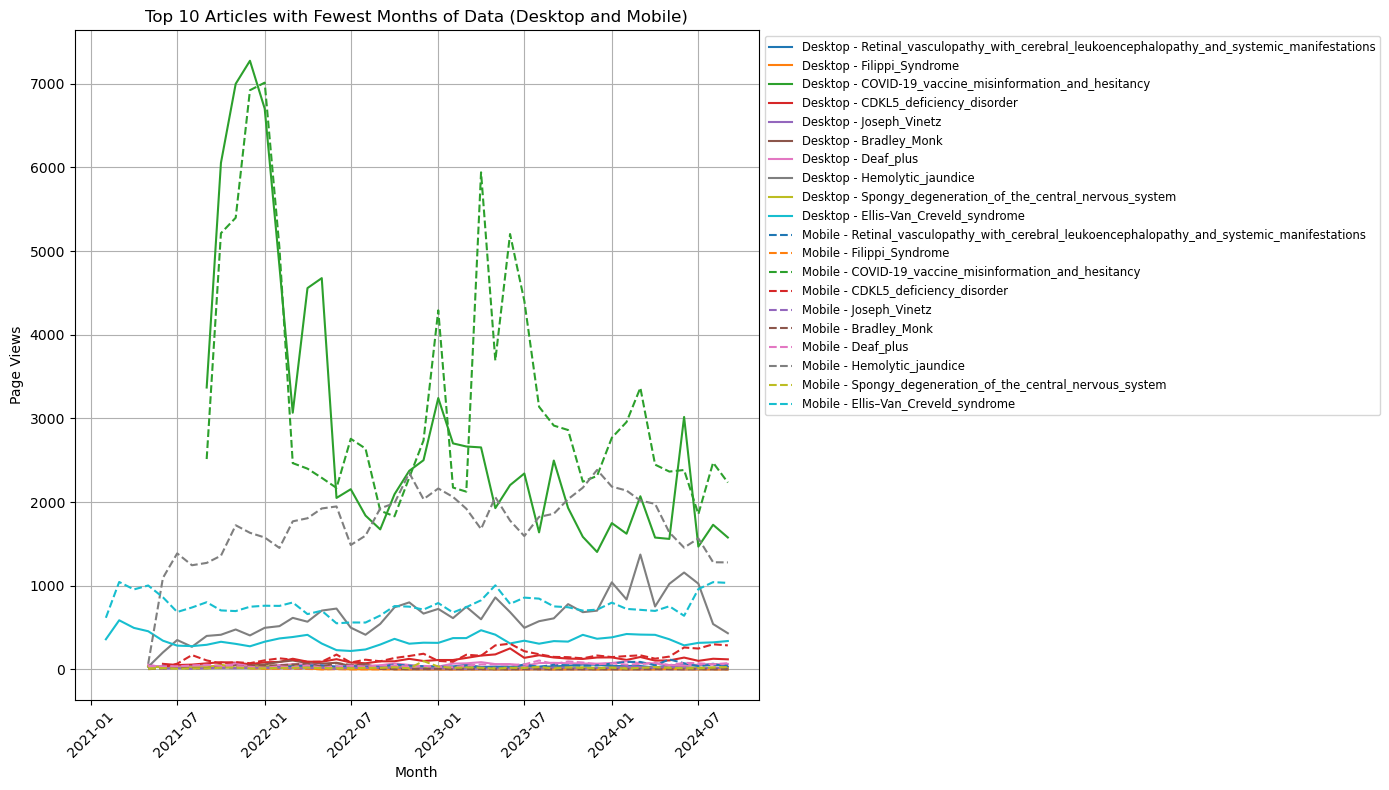

In [94]:
plt.figure(figsize=(14, 8))

for article in desktop_fewest_months['article']:
    article_data = top_desktop_articles[top_desktop_articles['article'] == article]
    plt.plot(article_data['month'].dt.to_timestamp(), article_data['views'], label=f'Desktop - {article}', linestyle='-')

for article in desktop_fewest_months['article']:
    article_data = top_mobile_articles[top_mobile_articles['article'] == article]
    plt.plot(article_data['month'].dt.to_timestamp(), article_data['views'], label=f'Mobile - {article}', linestyle='--')

# Customize the plot
plt.title('Top 10 Articles with Fewest Months of Data (Desktop and Mobile)')
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Fewest Months of Data.png')  
plt.show()  